In [6]:
# Fichiers bruts
file_list = glob.glob('../data/fev/17*')
data = file_list
# Dictionnaires : {angle: chemin}
classic_dict = {}
excav_dict = {}

# Remplissage
for file in file_list:
    match = re.search(r'v_(\d+)deg', file)
    if match:
        angle = int(match.group(1))
        if "excav" in file:
            excav_dict[angle] = file
        else:
            classic_dict[angle] = file

# Angles communs aux deux jeux
common_angles = sorted(set(classic_dict.keys()) & set(excav_dict.keys()))

# Création des listes triées
data_classic = [classic_dict[a] for a in common_angles]
data_excav = [excav_dict[a] for a in common_angles]

In [70]:
import numpy as np
import pandas as pd
import glob as glob 
import os
import pathlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

import utils2
from itertools import groupby
from operator import itemgetter

import re
from collections import defaultdict


def get_air(angle_incident, range_):
    theta_deg = 25
    phi_deg = 16

    theta_rad = np.radians(theta_deg)
    phi_rad = np.radians(phi_deg)

    return (np.pi * range_**2 * theta_rad * phi_rad) / (8 * np.log(2) * np.cos(angle_incident))


def get_sigma0(df,angle_inc,pad_factor): 

    angle_rad = np.radians(angle_inc)
    
    # Paramètres
    threshold = 5e-3  # seuil de dérivée
    min_bins_stable = 20 *pad_factor # nombre minimal de bins consécutifs stables

    usefull_df = df.loc[0.5:10]

    # Calcul de sigma0 instantané
    sigma_raw = (usefull_df['copol'] ** 2) * (usefull_df.index ** 4) / 0.001

    # Normalisation par la surface projetée du faisceau
    air = get_air(angle_rad, usefull_df.index.values)
    delta_r = np.diff(usefull_df.index.values).mean()  # largeur moyenne d’un bin en mètres
    sigma = (sigma_raw / air) * delta_r
    # sigma = (sigma_raw / air) 
    
    # Calcul du log10 de la somme cumulée
    sigma_cumsum_log = np.log10(np.cumsum(sigma.values))
    
    # Approximation de la dérivée
    dsigma = np.gradient(sigma_cumsum_log)
    
    # Création d’un DataFrame temporaire
    sigma_df = pd.DataFrame({
        'range': sigma.index.values,
        'sigma_log': sigma_cumsum_log,
        'dsigma': dsigma
    })
    
    # Masque binaire : 1 si la dérivée est inférieure au seuil
    stable_mask = np.abs(sigma_df['dsigma'].values) < threshold
    
    # Trouver les groupes d'indices stables
    stable_indices = [i for i, val in enumerate(stable_mask) if val]
    
    # Groupes de consécutifs
    for k, g in groupby(enumerate(stable_indices), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        if len(group) >= min_bins_stable:
            first_stable_idx = group[0]
            stable_value_db = 10 * sigma_df.loc[first_stable_idx, 'sigma_log']
            stable_range = sigma_df.loc[first_stable_idx, 'range']
            # print(f"Valeur stabilisée de Sigma : {stable_value_db:.2f} dB à Range = {stable_range:.3f}")
            break
    else:
        stable_value_db = np.nan
        # print("Pas de stabilisation détectée sur une plage suffisante.")

    return stable_value_db,stable_range


def plot_spectres_sigma0_vs_padding(filepath, beta, angle_inc):
    pad_factors = [1, 8]
    colors = ['black', 'blue', 'green', 'red', 'purple']

    plt.figure(figsize=(10, 6))
    
    for pad, color in zip(pad_factors, colors):
        df, name = utils2.raw_to_mean_spectrum(filepath, beta=beta, pad_factor=pad)
        df = df.loc[0.5:5]  # limiter la plage de distances

        sigma0_db, stable_range = get_sigma0(df, angle_inc,pad_factor=pad)

        # Affichage en linéaire (non dB)
        plt.plot(df.index, df['copol'],
                 label=f'Pad x{pad} | σ⁰ = {sigma0_db:.1f} dB',
                 color=color)

        # Affichage du point de stabilisation
        if not np.isnan(sigma0_db):
            y_val = df.loc[stable_range, 'copol']
            plt.plot(stable_range, y_val, 'o', color=color)
            plt.annotate(f'{stable_range:.2f} m',
                         xy=(stable_range, y_val),
                         xytext=(stable_range + 0.1, y_val * 1.5),
                         arrowprops=dict(arrowstyle='->', color=color),
                         fontsize=8, color=color)

    plt.xlabel("Distance (m)")
    plt.ylabel("Spectre copolaire (linéaire)")
    plt.title(f"Fichier: {name}")
    plt.ylim(0, None)  # auto-limite avec haut dynamique
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


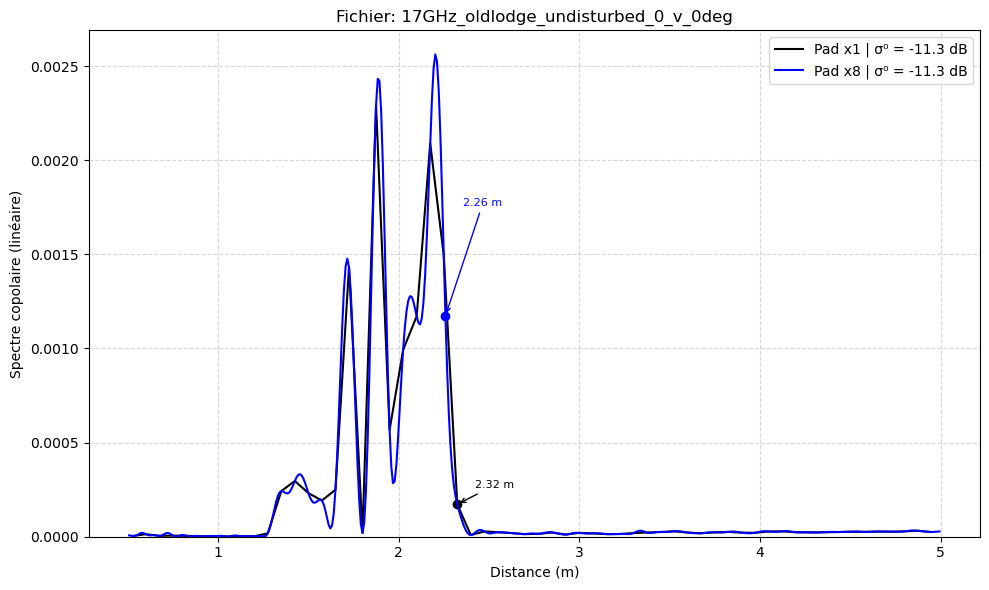

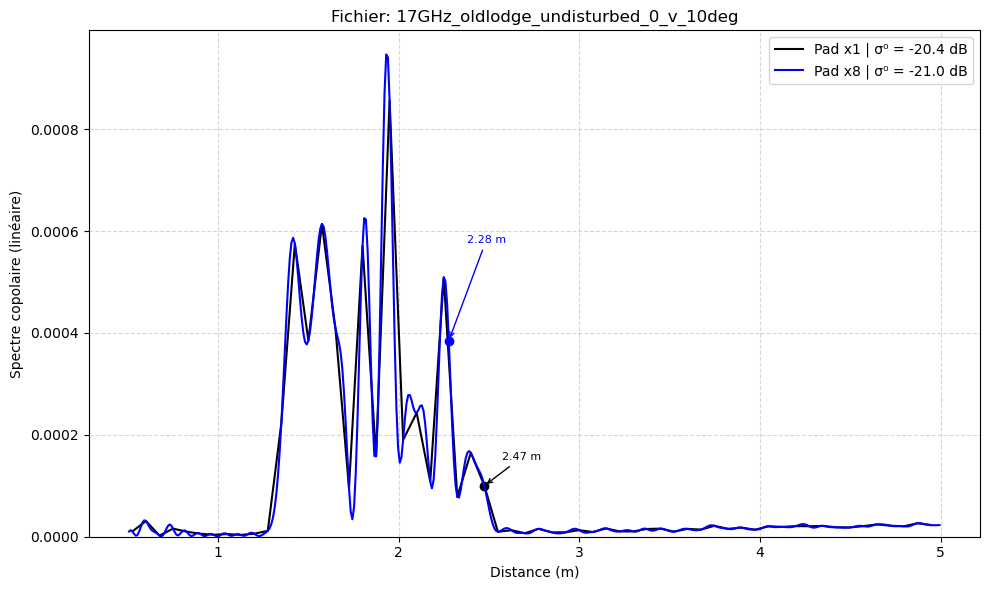

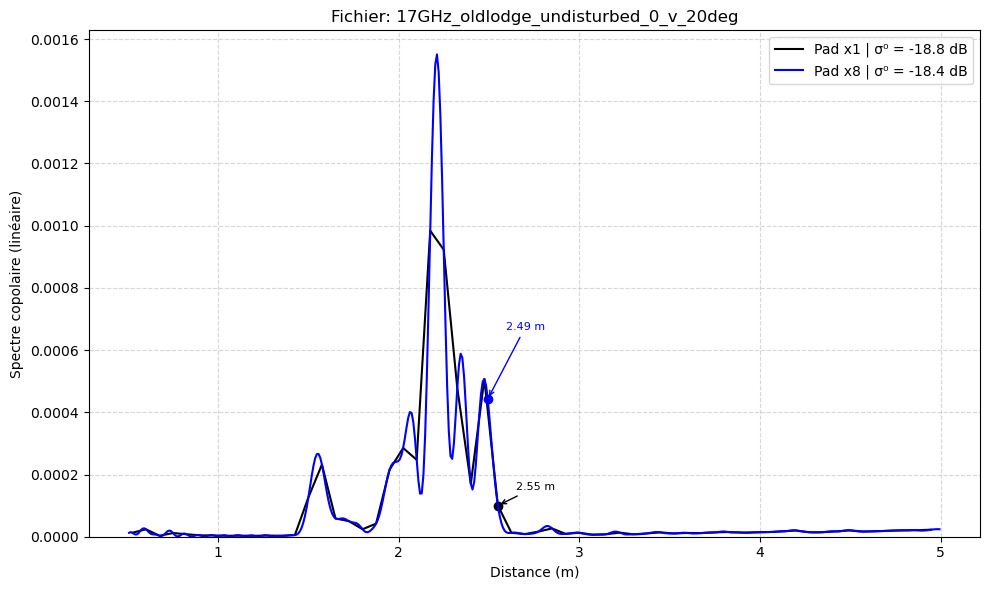

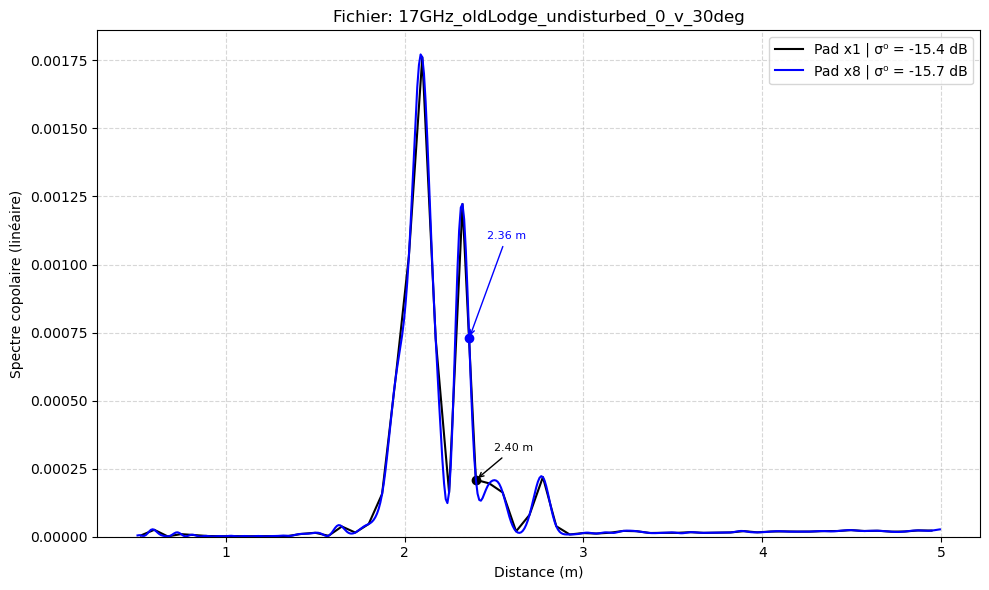

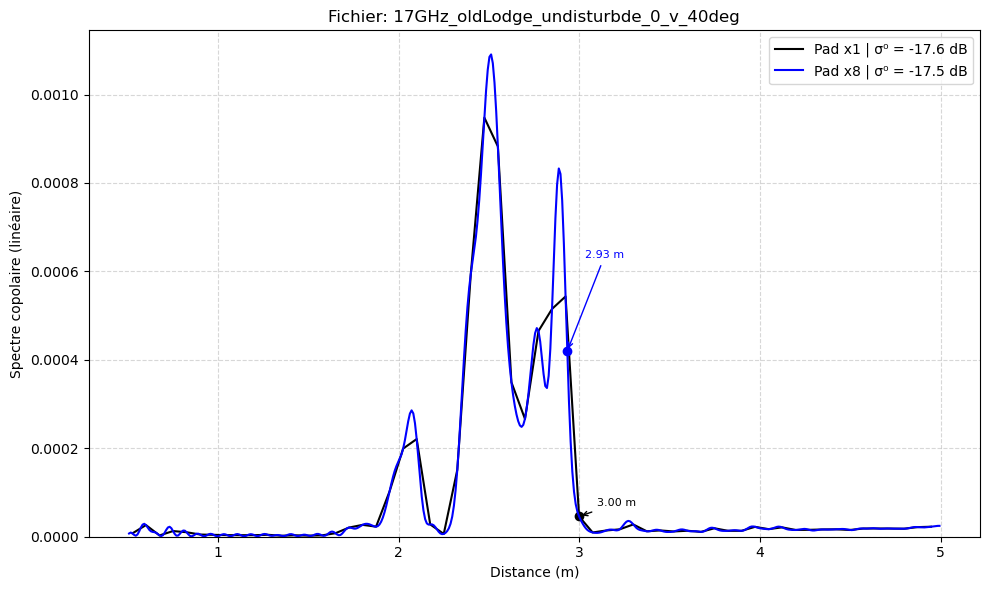

In [71]:
j=0
for i in data_classic : 
    plot_spectres_sigma0_vs_padding(i, beta=5, angle_inc=common_angles[j])
    j+=1